In [1]:
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
import xarray as xr
import geohash
%matplotlib inline

In [2]:
def plot_box(ax, code, color, caption=True):
    """Plot a GeoHash bounding box"""
    box = geohash.string.bounding_box(code)
    x0 = box.min_corner.lng
    x1 = box.max_corner.lng
    y0 = box.min_corner.lat
    y1 = box.max_corner.lat
    dx = x1 - x0
    dy = y1 - y0
    box = mpatch.Rectangle(
        (x0, y0), dx, dy,
        alpha=0.5, color=color, ec="black", lw=1, transform=ccrs.PlateCarree())
    ax.add_artist(box)
    if not caption:
        return
    rx, ry = box.get_xy()
    cx = rx + box.get_width() * 0.5
    cy = ry + box.get_height() * 0.5
    ax.annotate(code.decode(), (cx, cy), color='w', weight='bold', 
                fontsize=16, ha='center', va='center')

In [3]:
def sort_colors(colors):
    """Sort colors by hue, saturation, value and name in descending order"""
    by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                     name)
                    for name, color in colors.items())
    return [name for hsv, name in reversed(by_hsv)]    

In [4]:
def plot(codes, points=None, color_list=None, inc=7):
    """Plot geohash bounding boxes"""
    color_list = color_list or mcolors.CSS4_COLORS
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    if points is not None:
        xmin, xmax = points['lng'].min(), points['lng'].max()
        ymin, ymax = points['lat'].min(), points['lat'].max()
        ax.set_xlim((xmin - 4, xmax + 4))
        ax.set_ylim((ymin - 4, ymax + 4))

        ax.plot(points['lng'], points['lat'], color='black', marker=".",
                ls='', ms='0.5', transform=ccrs.PlateCarree())
    colors = sort_colors(color_list)
    ic = 0
    color_codes = {codes[0][0]: colors[ic]}
    for ix, item in enumerate(codes):
        prefix = item[0]
        if prefix not in color_codes:
            ic += inc
            color_codes[prefix] = colors[ic % len(colors)]
        plot_box(ax, item, color_codes[prefix], True)
    ax.stock_img()
    ax.coastlines()
    ax.grid()

## Visualization of GeoHash codes, accuracy 2 (10-bit)

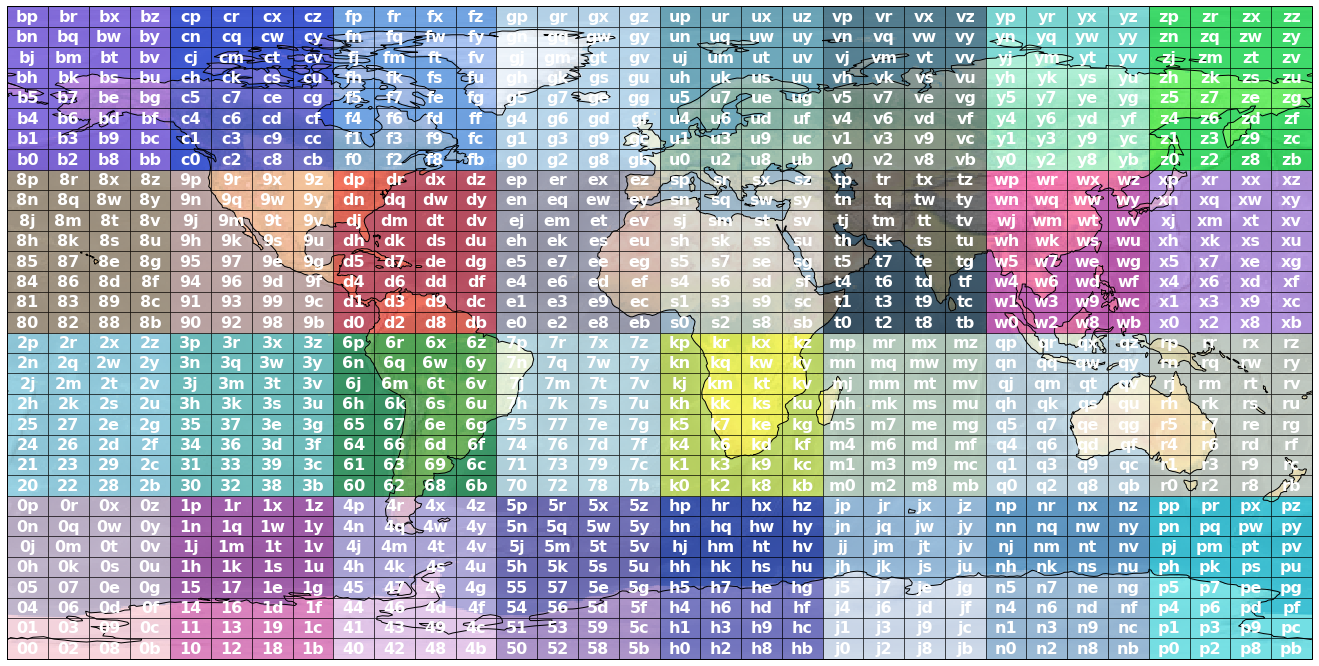

In [5]:
plot(geohash.string.bounding_boxes(precision=2))

## Indexing a SWOT pass.

In [6]:
ds = xr.load_dataset("swot_karin_c001_p020.nc", group="basic")

In [7]:
ds

<xarray.Dataset>
Dimensions:                                (num_lines: 9867, num_pixels: 52, num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 77.12 ... -77.12
    longitude                              (num_lines, num_pixels) float64 286.2 ... 93.22
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables:
    time                                   (num_lines) datetime64[ns] 2020-04-18T08:21:36.028257920 ... 2020-04-18T09:12:41.311697920
    time_tai                               (num_lines) datetime64[ns] NaT ... NaT
    ssh_karin                              (num_lines, num_pixels) float64 nan ... nan
    ssh_karin_uncert                       (num_lines, num_pixels) float32 nan ... nan
    ssha_karin                             (num_lines, num_pixels) float64 nan ... nan
    ssh_karin_2                            (num_lines, num_pixels) float64 nan ... nan
    ssha_karin_2                           (num_lines, num_pixels) float64 nan ... nan
    num_pt_avg                             (num_lines, num_pixels) float32 nan ... nan
    ssha_karin_qual                        (num_lines, num_pixels) float64 nan ... nan
    distance_to_coast                      (num_lines, num_pixels) float32 nan ... nan
    heading_to_coast                       (num_lines, num_pixels) float32 nan ... nan
    ancillary_surface_classification_flag  (num_lines, num_pixels) float32 nan ... nan
    dynamic_ice_flag                       (num_lines, num_pixels) float32 nan ... nan
    rain_flag                              (num_lines, num_pixels) float32 nan ... nan
    rad_surface_type_flag                  (num_lines, num_sides) float32 nan ... nan
    mean_sea_surface_sol1                  (num_lines, num_pixels) float64 nan ... nan
    mean_sea_surface_sol1_uncert           (num_lines, num_pixels) float32 nan ... nan
    geoid                                  (num_lines, num_pixels) float64 nan ... nan
    internal_tide_sol1                     (num_lines, num_pixels) float32 nan ... nan
    height_cor_xover                       (num_lines, num_pixels) float64 nan ... nan
Attributes:
    description:  Basic SSH measurement data and related information for the ...

Creation of a numpy matrix containing the coordinates of the points to be indexed.

In [8]:
points = np.empty(ds.longitude.shape, dtype=geohash.POINT_DTYPE)
# Put longitude between [-180, 180[
points['lng'] = (ds.longitude + 180) % 360 - 180
points['lat'] = ds.latitude

Calculation of the GeoHash codes of the different satellite positions.

In [9]:
codes = geohash.string.encode(points.flatten(), precision=2).reshape(points.shape)

Visualization of the different GeoHash codes found.

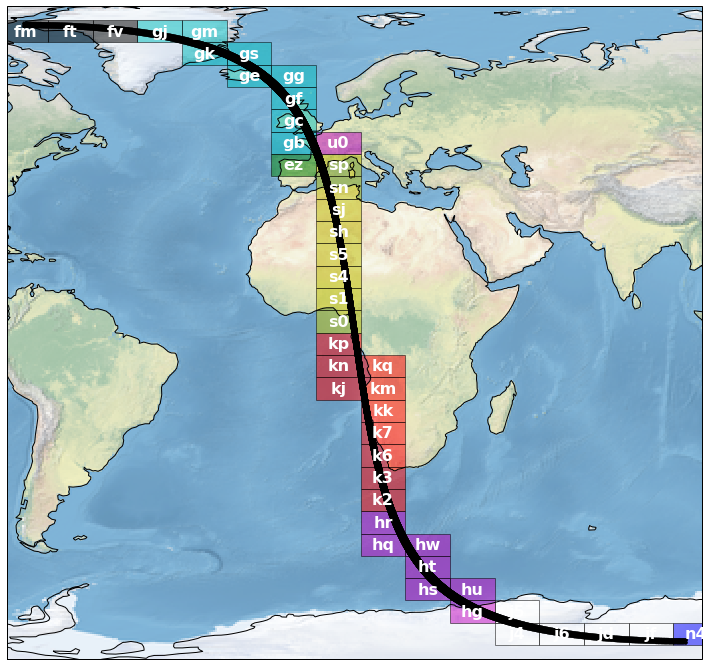

In [10]:
plot(list(set(codes.flatten())), points, color_list=mcolors.BASE_COLORS, inc=1)

Calculation of the indexes delimiting each bounding box found. It is this information that we can store in order to quickly load a given area into memory.

In [11]:
indexes = geohash.string.where(codes)

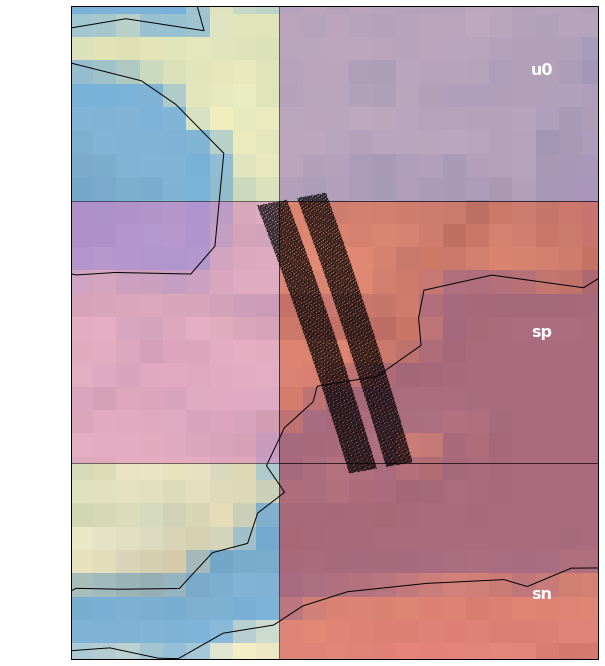

In [12]:
coordinates = indexes[b'sp']
plot(list(set(codes[slice(*coordinates[0]), slice(*coordinates[1])].flatten())),
     points[slice(*coordinates[0]), slice(*coordinates[1])],
     color_list=mcolors.TABLEAU_COLORS,
     inc=1)